In [1]:
#█    ▀  █▀▀▄ █▀▀█ █▀▀█ █▀▀█ █  █ █▀▀ 
#█   ▀█▀ █▀▀▄ █▄▄▀ █▄▄█ █▄▄▀ █▄▄█ ▀▀█ 
#▀▀▀ ▀▀▀ ▀▀▀  ▀ ▀▀ ▀  ▀ ▀ ▀▀ ▄▄▄█ ▀▀▀ 
#

import time
import pandas as pd
import datetime

from numpy import log, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import rand 
seed = 1

import pyspark.sql.functions as F

from pyspark.sql.types import *
from pyspark.sql.functions import col

from pyspark.sql import SparkSession
import warnings

#variable for skipping all the plotting code for debugging processing
plotting = True


#█▀ █▀█ ▄▀█ █▀█ █▄▀ 
#▄█ █▀▀ █▀█ █▀▄ █ █ 
# spark set up

#removes warnings
warnings.filterwarnings("ignore")

# create a spark session (which will run spark jobs)
spark = SparkSession.builder.getOrCreate()

# makes the outputted df nicely formatted
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)



#█▀▄ ▄▀█ ▀█▀ ▄▀█    █▀▄ █ █▀█ 
#█▄▀ █▀█  █  █▀█    █▄▀ █ █▀▄ 
#

#main data directory
data_dir = "/mnt/e/2021/Applied Data Science/Project 1/Data/"

#▀█▀ ▄▀█ ▀▄▀ █    █▀▄ ▄▀█ ▀█▀ ▄▀█ 
# █  █▀█ █ █ █    █▄▀ █▀█  █  █▀█ 
#

#file location
file_base = "_tripdata_"

#indexs for each of the main data set types
ywl_i = 0 
grn_i = 1
fhv_i = 2
hvf_i = 3
taxi_types_n = 4

#names related to each cab type in order
taxi_file_names = ["yellow","green","fhv","fhvhv"]
full_names = ["yellow cabs", "green cabs", "for higher vheciles", "for higher high volume"]

#column names for each cab type in order
column_names = [
    ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge'],
    ['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
    ['dispatching_base_num', 'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID', 'SR_Flag'],
    ['hvfhs_license_num', 'dispatching_base_num', 'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID', 'SR_Flag']
]

#2018 fhv files which was giving me trouble so added this schema for it
bad_fhv_schema = [2, 2018, ['Pickup_DateTime','DropOff_datetime', 'PULocationID', 'DOLocationID', 'SR_Flag','dispatching_base_number']]


#aliases for pickup time and dropoff time
pickup_time = ['tpep_pickup_datetime','lpep_pickup_datetime','pickup_datetime','pickup_datetime','Pickup_DateTime']
dropoff_time = ['tpep_dropoff_datetime','lpep_dropoff_datetime','dropoff_datetime','dropoff_datetime','DropOff_datetime']

#irrelavent collumns that can be dropped
irrelavent_columns = ['dispatching_base_number','DOtime','hvfhs_license_num','dispatching_base_num','VendorID','store_and_fwd_flag','extra','MTA_tax','improvement_surcharge','tip_amount','tolls_amount', 'ehail_fee', 'improvement_surcharge', 'congestion_surcharge']


#▀█▀ ▄▀█ ▀▄▀ █    █   █▀█ █▀▀ ▄▀█ ▀█▀ █ █▀█ █▄ █ █▀ 
# █  █▀█ █ █ █    █▄▄ █▄█ █▄▄ █▀█  █  █ █▄█ █ ▀█ ▄█ 
#

#location processing variables
#locations that will be removed as considered invalid
bad_locations = [1,132,138,264,265]

#location of the location id file
location_file = "taxi+_zone_lookup.csv"

#list of boroughs names as in the location file
boroughs = ["Bronx","Brooklyn","Manhattan","Queens","Staten Island","EWR","Unknown"]


#█▀▄ ▄▀█ ▀█▀ █▀▀    █▀▄ █▀▀ █▀▀ █▀ 
#█▄▀ █▀█  █  ██▄    █▄▀ ██▄ █▀  ▄█ 
#
months_in_year = 12

#years of data used
years = [2018, 2019, 2020]

#feb 2019 was when fhvhv file started
fhvhv_started = [2,2019] 

#late feb 2020 was when the first case of covid was observed in NYC
covid_started = [2,2020] 

#preprocessing arrays

#hours each day to seperate each count
day_time_breakdown = [0,6,12,18]

#day of the year covid started on
start_day = int(datetime.datetime.strptime(
    " ".join([str(int) for int in covid_started]), 
    "%m %Y").__format__("%j"))

#pretty self explanitory
days_in_2020 = 366


#█▀█ █ █ ▀█▀ █   █ █▀▀ █▀█ █▀ 
#█▄█ █▄█  █  █▄▄ █ ██▄ █▀▄ ▄█ 
#

outlier_percent = 0.01
fare_amount_graph_buffer = 15
percentile_accuracy = 0.00001


#█▀▀ █▀█ █ █ █ █▀▄    █▀▄ █▀▀ █▀▀ █▀ 
#█▄▄ █▄█ ▀▄▀ █ █▄▀    █▄▀ ██▄ █▄▄ ▄█ 
#

#files
covid_restrictions_file = "covid_restrictions.csv"
covid_cases_file = "COVID-19_Daily_Counts_of_Cases__Hospitalizations__and_Deaths.csv"

#list of boroughs as named in the covid file (same order)
covid_boroughs =["bx","bk","mn","qn","si"]

#covid data of interest
covid_of_interest = ['case_count', 'probable_case_count','hospitalized_count', 'death_count', 'probable_death_count',
       'case_count_7day_avg', 'all_case_count_7day_avg', 'hospitalized_count_7day_avg',
       'death_count_7day_avg', 'all_death_count_7day_avg']




output_file = "combined_taxi_data.csv"



21/08/08 02:16:47 WARN Utils: Your hostname, DESKTOP-GN6J0KT resolves to a loopback address: 127.0.1.1; using 172.20.86.68 instead (on interface eth0)
21/08/08 02:16:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/08 02:16:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
#█▀▀ █▀▀ █  █ █▀▀ █▀▄▀█ █▀▀█    █▀▀ █▀▀ ▀▀█▀▀ █  █ █▀▀█ 
#▀▀█ █   █▀▀█ █▀▀ █ ▀ █ █▄▄█    ▀▀█ █▀▀   █   █  █ █▄▄█ 
#▀▀▀ ▀▀▀ ▀  ▀ ▀▀▀ ▀   ▀ ▀  ▀    ▀▀▀ ▀▀▀   ▀    ▀▀▀ █    
#

ints = ('SR_Flag','VendorID', 'trip_type', 'passenger_count', 'RateCodeID', 'RatecodeID','payment_type','PULocationID','DOLocationID')
doubles = ('trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','ehail_fee',
           'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount','congestion_surcharge')
strings = ('dispatching_base_number','store_and_fwd_flag','dispatching_base_num','hvfhs_license_num')
dtimes = ('DropOff_datetime','Pickup_DateTime','tpep_pickup_datetime', 'tpep_dropoff_datetime', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'pickup_datetime', 'dropoff_datetime')

dtypes = {column: IntegerType() for column in ints}
dtypes.update({column: DoubleType() for column in doubles})
dtypes.update({column: StringType() for column in strings})
dtypes.update({column: TimestampType() for column in dtimes})





#schema generation used from the tutes
schema = []
for index in range(0,taxi_types_n):
    schema.append(StructType())
    for column in column_names[index]:
        schema[index].add(column, # column name
                   dtypes[column], # data type
                   True # is nullable?
                  )
        
        
        
#schema for the bad fhv file
bad_fhv_schema.append(StructType())
for column in bad_fhv_schema[2]:
    bad_fhv_schema[3].add(column,
                         dtypes[column],
                         True)

In [3]:
#██╗ ███╗   ███╗ ██████╗   ██████╗  ██████╗  ████████╗ ██╗ ███╗   ██╗  ██████╗  
#██║ ████╗ ████║ ██╔══██╗ ██╔═══██╗ ██╔══██╗ ╚══██╔══╝ ██║ ████╗  ██║ ██╔════╝  
#██║ ██╔████╔██║ ██████╔╝ ██║   ██║ ██████╔╝    ██║    ██║ ██╔██╗ ██║ ██║  ███╗ 
#██║ ██║╚██╔╝██║ ██╔═══╝  ██║   ██║ ██╔══██╗    ██║    ██║ ██║╚██╗██║ ██║   ██║ 
#██║ ██║ ╚═╝ ██║ ██║      ╚██████╔╝ ██║  ██║    ██║    ██║ ██║ ╚████║ ╚██████╔╝ 
#╚═╝ ╚═╝     ╚═╝ ╚═╝       ╚═════╝  ╚═╝  ╚═╝    ╚═╝    ╚═╝ ╚═╝  ╚═══╝  ╚═════╝  
# imports all the relavent csv files to 


#▀█▀ ▄▀█ ▀▄▀ █ 
# █  █▀█ █ █ █ 
#
def read_csv(year, month, taxi_i, schema_used, drop_index):
    return (
        spark.read.csv(
            data_dir + taxi_file_names[taxi_i] + file_base + str(year) + "-" + str(month).zfill(2) + ".csv", 
            header=True, 
            schema=schema_used)\
        .withColumnRenamed(pickup_time[drop_index],"PUtime")# rename the time col
        .withColumnRenamed(dropoff_time[drop_index],"DOtime")# rename other time col
        .drop(*irrelavent_columns)
        #.sample(False, 0.1, seed=seed).limit(10) #testing line        
    )


#spark data frame matrix
dfm = {}

for year in years:
    dfm[year] = {}
    
    #for each taxi variant
    for taxi_i in range(0,len(taxi_file_names)):
        dfm[year][taxi_i] = 0
           
        #loops over the months in years
        for month in range(covid_started[0], months_in_year + 1):
            
            if(bad_fhv_schema[1] == year and taxi_i == fhv_i):
                
                schema_used = bad_fhv_schema[3]
                drop_index = 4
            else:
                schema_used = schema[taxi_i]
                drop_index = taxi_i
                
                    
                    
            
            #small condition as fhvhv didnt always exist
            if( (month >= fhvhv_started[0] and year >= fhvhv_started[1]) or taxi_i != hvf_i):
                
                #prints that the functions is processing
                print("importing " + taxi_file_names[taxi_i] + "    \t" + str(year) + "-" + str(month).zfill(2))                
                
                
                #checks if a df has been read to current taxi or not
                if dfm[year][taxi_i]:
                    
                    print("adding")
                    #if its valid the df is added
                    dfm[year][taxi_i] = dfm[year][taxi_i].union(read_csv(year, month, taxi_i, schema_used, drop_index))
                else:
                    
                    print("making")
                    #reads the first dataframe
                    dfm[year][taxi_i] = read_csv(year, month, taxi_i, schema_used, drop_index)
            
            else:
                dfm[year][taxi_i] = None

for year in years:
    for taxi_i in range(0,len(taxi_file_names)):
        if( dfm[year][taxi_i] ):
            dfm[year][taxi_i] = dfm[year][taxi_i]#.orderBy(rand(seed=seed))).limit(1000)

importing yellow    	2018-02
making
importing yellow    	2018-03
adding
importing yellow    	2018-04
adding
importing yellow    	2018-05
adding
importing yellow    	2018-06
adding
importing yellow    	2018-07
adding
importing yellow    	2018-08
adding
importing yellow    	2018-09
adding
importing yellow    	2018-10
adding
importing yellow    	2018-11
adding
importing yellow    	2018-12
adding
importing green    	2018-02
making
importing green    	2018-03
adding
importing green    	2018-04
adding
importing green    	2018-05
adding
importing green    	2018-06
adding
importing green    	2018-07
adding
importing green    	2018-08
adding
importing green    	2018-09
adding
importing green    	2018-10
adding
importing green    	2018-11
adding
importing green    	2018-12
adding
importing fhv    	2018-02
making
importing fhv    	2018-03
adding
importing fhv    	2018-04
adding
importing fhv    	2018-05
adding
importing fhv    	2018-06
adding
importing fhv    	2018-07
adding
importing fhv    	201

In [4]:
#█▀▀ ▄▀█ █▀ █▀▀ █▀ 
#█▄▄ █▀█ ▄█ ██▄ ▄█ 
# #importing covid case data
covid_cases = pd.read_csv(data_dir + covid_cases_file)

#makes the names of columns lowercase
covid_cases.columns = covid_cases.columns.str.lower()

#makes the date column datetime object
covid_cases['date_of_interest'] = covid_cases['date_of_interest']\
    .transform(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

#renaming some badly named columns
covid_cases['probable_death_count'] = covid_cases['death_count_probable']
covid_cases['hospitalized_count_7day_avg'] = covid_cases['hosp_count_7day_avg']
covid_cases = covid_cases.drop(['death_count_probable','hosp_count_7day_avg'],axis=1)

In [5]:
#█▀█ █▀▀ █▀ ▀█▀ █▀█ █ █▀▀ ▀█▀ █ █▀█ █▄ █ █▀ 
#█▀▄ ██▄ ▄█  █  █▀▄ █ █▄▄  █  █ █▄█ █ ▀█ ▄█ 
#

#importing covid restrictions data
covid_restrictions = pd.read_csv(data_dir + covid_restrictions_file)

In [6]:
if plotting:
    
    dft = dfm[2019][ywl_i].sample(False, 0.1, seed=0).limit(10000)
    
    #extracting all the 
    data = dft.select('fare_amount').toPandas()['fare_amount']
    
    # apply a log transformation for all x non-zero x points, else 0
    dataL = data.apply(lambda x: log(x) if x else 0)

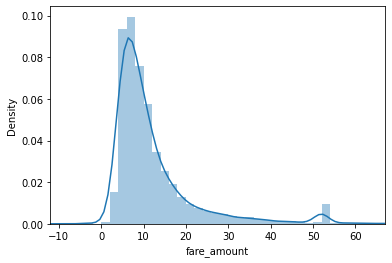

In [7]:
if plotting:
    sns.distplot(data, bins= round((data.max()-data.min())/(2)))
    plt.xlim(data.quantile(outlier_percent)-fare_amount_graph_buffer, data.quantile(1-outlier_percent)+fare_amount_graph_buffer)
    plt.show()

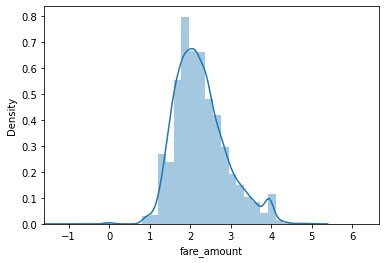

In [8]:
if plotting:
    plt.xlim(dataL.quantile(outlier_percent)-log(fare_amount_graph_buffer), dataL.quantile(1-outlier_percent)+log(fare_amount_graph_buffer))
    sns.distplot(dataL, bins= round((dataL.max()-data.min()))*2)
    plt.show()
    
    #tried other plots and they looked like shit

In [9]:
if plotting:
    
    #extracting all the 
    data = dft.select('trip_distance').toPandas()['trip_distance']
    
    # apply a log transformation for all x non-zero x points, else 0
    dataL = data.apply(lambda x: log(x) if x else 0)

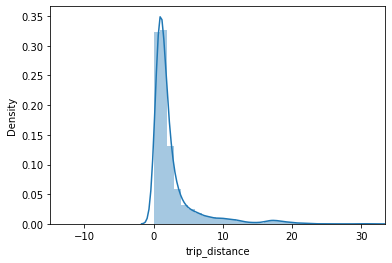

In [10]:
if plotting:
    plt.xlim(data.quantile(outlier_percent)-fare_amount_graph_buffer, data.quantile(1-outlier_percent)+fare_amount_graph_buffer)
    sns.distplot(data, bins= round((data.max()-data.min())*1))
    plt.show()

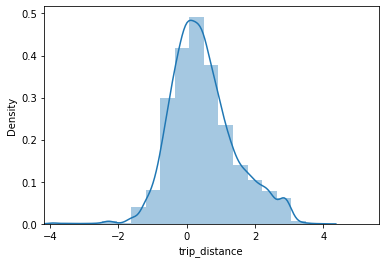

In [11]:
if plotting:
    plt.xlim(dataL.quantile(outlier_percent)-log(fare_amount_graph_buffer), dataL.quantile(1-outlier_percent)+log(fare_amount_graph_buffer))
    sns.distplot(dataL, bins= round((dataL.max()-data.min()))*5)
    plt.show()

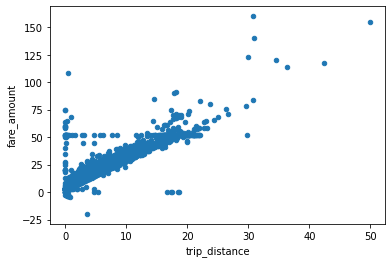

In [12]:
if plotting:
    data = dft.select('fare_amount','trip_distance').toPandas()
    data.plot.scatter(y='fare_amount',x='trip_distance')

In [13]:
#███████╗ ██╗ ██╗      ████████╗ ███████╗ ██████╗  ██╗ ███╗   ██╗  ██████╗  
#██╔════╝ ██║ ██║      ╚══██╔══╝ ██╔════╝ ██╔══██╗ ██║ ████╗  ██║ ██╔════╝  
#█████╗   ██║ ██║         ██║    █████╗   ██████╔╝ ██║ ██╔██╗ ██║ ██║  ███╗ 
#██╔══╝   ██║ ██║         ██║    ██╔══╝   ██╔══██╗ ██║ ██║╚██╗██║ ██║   ██║ 
#██║      ██║ ███████╗    ██║    ███████╗ ██║  ██║ ██║ ██║ ╚████║ ╚██████╔╝ 
#╚═╝      ╚═╝ ╚══════╝    ╚═╝    ╚══════╝ ╚═╝  ╚═╝ ╚═╝ ╚═╝  ╚═══╝  ╚═════╝  
# removing values that dont make sense, etc


#█   █▀█ █▀▀ ▄▀█ ▀█▀ █ █▀█ █▄ █ 
#█▄▄ █▄█ █▄▄ █▀█  █  █ █▄█ █ ▀█ 
# removing invalid locations

#checks if location id is in the bad location list
@F.udf("boolean")
def bad_location(LocationID):
    if(LocationID):
        return (int(LocationID) not in bad_locations)
    else:
        return False

#for each year and each taxi 
for year in years:
    for taxi_i in range(0,len(taxi_file_names)):
        if( dfm[year][taxi_i] ):
            
            print("processing " + str(year) + " " + taxi_file_names[taxi_i])
            dfm[year][taxi_i] = dfm[year][taxi_i]\
                .filter(
                    (bad_location(col("PULocationID"))) &
                    (bad_location(col("DOLocationID")))
                       )

processing 2018 yellow
processing 2018 green
processing 2018 fhv
processing 2019 yellow
processing 2019 green
processing 2019 fhv
processing 2019 fhvhv
processing 2020 yellow
processing 2020 green
processing 2020 fhv
processing 2020 fhvhv


In [14]:
for year in years:
    for taxi_i in [fhv_i, hvf_i]:
        if( dfm[year][taxi_i] ):
            dfm[year][taxi_i] = dfm[year][taxi_i]\
            .filter(
                (col("SR_flag").isNull())
            ).drop("SR_flag")
        

In [15]:
#the following processing only makes sense for yellow and green taxis


#█▀█ ▄▀█ █▀ █▀ █▀▀ █▄ █ █▀▀ █▀▀ █▀█ 
#█▀▀ █▀█ ▄█ ▄█ ██▄ █ ▀█ █▄█ ██▄ █▀▄ 
# removing invalid passenger counts

#█▀█ ▄▀█ ▀█▀ █▀▀ █▀ 
#█▀▄ █▀█  █  ██▄ ▄█ 
# only keep standard rates

#█▀█ ▄▀█ █▄█ █▀▄▀█ █▀▀ █▄ █ ▀█▀ 
#█▀▀ █▀█  █  █ ▀ █ ██▄ █ ▀█  █  
# payment types which arent helpful
for year in years:
    for taxi_i in [ywl_i, grn_i]:
        if( dfm[year][taxi_i] ):
            dfm[year][taxi_i] = dfm[year][taxi_i]\
            .filter(
                (
                    (col("payment_type") == 1) | 
                    (col("payment_type") == 0)
                ) &
                (col("passenger_count") > 0) &
                (col("RateCodeID") == 1)
            )#.drop("RateCodeID","passenger_count","payment_type")
             
                
                


Traceback (most recent call last):                                  (0 + 1) / 1]
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


[2.5, 83.5]


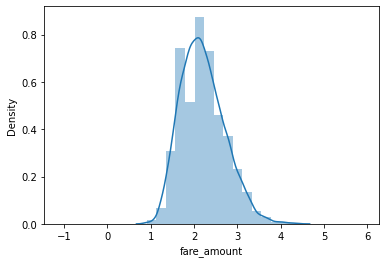

In [16]:
#█▀▀ █▀█ █▀ ▀█▀    ▄▀█ █▀▄▀█ █▀█ █ █ █▄ █ ▀█▀ 
#█▄▄ █▄█ ▄█  █     █▀█ █ ▀ █ █▄█ █▄█ █ ▀█  █  
# cost are sometimes bad, graphing what it looks like atm

if plotting:
    
    dft = dfm[2019][ywl_i].sample(False, 0.1, seed=0).limit(10000)
    
    #extracting all the fare amounts
    data = dft.select('fare_amount').select('fare_amount').toPandas()['fare_amount']
    
    #checking max and min
    print([data.min(),data.max()])
    
    #taking the log transform 
    data = data.apply(lambda x: log(x) if x else 0)
    
    #plotting the log of fare amounts to view distribution
    plt.xlim(data.quantile(outlier_percent)-log(fare_amount_graph_buffer), data.quantile(1-outlier_percent)+log(fare_amount_graph_buffer))
    sns.distplot(data, bins= round((data.max()-data.min()))*4)
    plt.show()
    
    
    #dfm[2019][ywl_i].select("fare_amount").summary().show()

Traceback (most recent call last):
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


[0.0, 30.68]


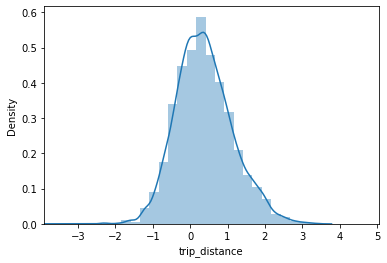

In [17]:
#▀█▀ █▀█ █ █▀█    █▀▄ █ █▀ ▀█▀ ▄▀█ █▄ █ █▀▀ █▀▀ 
# █  █▀▄ █ █▀▀    █▄▀ █ ▄█  █  █▀█ █ ▀█ █▄▄ ██▄ 
#

if plotting:
        
    #extracting all the fare amounts
    data = dft.select('trip_distance').toPandas()['trip_distance']
    
    #checking max and min
    print([data.min(),data.max()])
    
    #taking the log transform 
    data = data.apply(lambda x: log(x) if x else 0)
    
    #plotting the log of fare amounts to view distribution
    plt.xlim(data.quantile(outlier_percent)-log(fare_amount_graph_buffer), data.quantile(1-outlier_percent)+log(fare_amount_graph_buffer))
    sns.distplot(data, bins= round((data.max()-data.min()))*4)
    plt.show()
    
    
    #dfm[2019][ywl_i].select("fare_amount").summary().show()

Traceback (most recent call last):                                 (0 + 8) / 88]
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError
Traceback (most recent call last):                                 (1 + 8) / 88]
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in

Traceback (most recent call last):
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
Traceback (most recent call last):
EOFError
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zi

Traceback (most recent call last):                                (27 + 8) / 88]
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError
Traceback (most recent call last):                                (28 + 8) / 88]
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in

Traceback (most recent call last):==>                             (43 + 8) / 88]
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError
Traceback (most recent call last):
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3

Traceback (most recent call last):===========>                    (56 + 8) / 88]
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError
Traceback (most recent call last):===========>                    (57 + 8) / 88]
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in

Traceback (most recent call last):
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError
Traceback (most recent call last):====================>           (71 + 9) / 88]
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3

Traceback (most recent call last):
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/andre/.local/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/andre/.local/lib/python3.8/site-pac

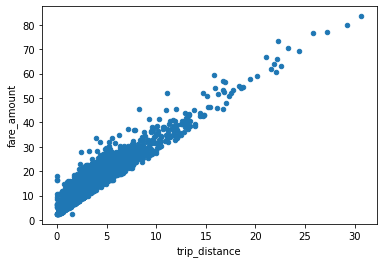

In [18]:
if plotting:
        
    data = dft.select('fare_amount','trip_distance').toPandas()
    data.plot.scatter(y='fare_amount',x='trip_distance')

In [19]:
#ass fare amount is obviously dependent on trip distance, the one quantiles cant be calculated after processing the other set
#so they must both be processed in the same filter

for year in years:
    for taxi_i in [ywl_i, grn_i]:
        if( dfm[year][taxi_i] ):
            
            print("processing " + str(year) + " " + taxi_file_names[taxi_i])
            qt = dfm[year][taxi_i].approxQuantile(
                ["fare_amount",'trip_distance'], 
                [outlier_percent,1-outlier_percent], 
                percentile_accuracy
            )
            print(qt)
            
            #2.5 is the miniumum fare_amount so if the fare quantile was lower than the minimum, it is raised
            if qt[0][0] < 2.5 :
                qt[0][0] = 2.5
            
            #less than a 0km trip shouldnt be counted so min of distance it set to 0 if it was lower.
            if qt[1][0] < 0 :
                qt[1][0] = 0
                
            #only keeps the middle percent% (depends on what percent was decided) to remove outliers 
            dfm[year][taxi_i] = dfm[year][taxi_i].filter(
                (col("fare_amount") > qt[0][0]) & 
                (col("fare_amount") < qt[0][1]) &                
                (col('trip_distance') > qt[1][0]) & 
                (col('trip_distance') < qt[1][1])
            )#.drop("fare_amount","total_amount"'trip_distance')
            


            

processing 2018 yellow


21/08/08 02:22:02 ERROR Executor: Exception in task 0.0 in stage 9.0 (TID 270)8]
java.lang.OutOfMemoryError: Java heap space
	at scala.collection.mutable.ResizableArray.ensureSize(ResizableArray.scala:106)
	at scala.collection.mutable.ResizableArray.ensureSize$(ResizableArray.scala:96)
	at scala.collection.mutable.ArrayBuffer.ensureSize(ArrayBuffer.scala:49)
	at scala.collection.mutable.ArrayBuffer.$plus$eq(ArrayBuffer.scala:85)
	at org.apache.spark.sql.catalyst.util.QuantileSummaries.merge(QuantileSummaries.scala:212)
	at org.apache.spark.sql.execution.stat.StatFunctions$.$anonfun$multipleApproxQuantiles$5(StatFunctions.scala:100)
	at org.apache.spark.sql.execution.stat.StatFunctions$$$Lambda$3027/1067707903.apply(Unknown Source)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:238)
	at scala.collection.TraversableLike$$Lambda$32/1763344271.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection

21/08/08 02:22:12 ERROR TaskSetManager: Task 0 in stage 9.0 failed 1 times; aborting job
21/08/08 02:22:12 ERROR TaskSchedulerImpl: Exception in statusUpdate
java.util.concurrent.RejectedExecutionException: Task org.apache.spark.scheduler.TaskResultGetter$$Lambda$3069/1404097192@1ce7f8ad rejected from java.util.concurrent.ThreadPoolExecutor@414c4fe0[Shutting down, pool size = 2, active threads = 0, queued tasks = 0, completed tasks = 271]
	at java.util.concurrent.ThreadPoolExecutor$AbortPolicy.rejectedExecution(ThreadPoolExecutor.java:2063)
	at java.util.concurrent.ThreadPoolExecutor.reject(ThreadPoolExecutor.java:830)
	at java.util.concurrent.ThreadPoolExecutor.execute(ThreadPoolExecutor.java:1379)
	at org.apache.spark.scheduler.TaskResultGetter.enqueueFailedTask(TaskResultGetter.scala:137)
	at org.apache.spark.scheduler.TaskSchedulerImpl.liftedTree2$1(TaskSchedulerImpl.scala:771)
	at org.apache.spark.scheduler.TaskSchedulerImpl.statusUpdate(TaskSchedulerImpl.scala:745)
	at org.apache

Py4JJavaError: An error occurred while calling o1870.approxQuantile.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 9.0 failed 1 times, most recent failure: Lost task 0.0 in stage 9.0 (TID 270) (172.20.86.68 executor driver): java.lang.OutOfMemoryError: Java heap space
	at scala.collection.mutable.ResizableArray.ensureSize(ResizableArray.scala:106)
	at scala.collection.mutable.ResizableArray.ensureSize$(ResizableArray.scala:96)
	at scala.collection.mutable.ArrayBuffer.ensureSize(ArrayBuffer.scala:49)
	at scala.collection.mutable.ArrayBuffer.$plus$eq(ArrayBuffer.scala:85)
	at org.apache.spark.sql.catalyst.util.QuantileSummaries.merge(QuantileSummaries.scala:212)
	at org.apache.spark.sql.execution.stat.StatFunctions$.$anonfun$multipleApproxQuantiles$5(StatFunctions.scala:100)
	at org.apache.spark.sql.execution.stat.StatFunctions$$$Lambda$3027/1067707903.apply(Unknown Source)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:238)
	at scala.collection.TraversableLike$$Lambda$32/1763344271.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.map(TraversableLike.scala:238)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:231)
	at scala.collection.mutable.ArrayOps$ofRef.map(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.stat.StatFunctions$.merge$1(StatFunctions.scala:100)
	at org.apache.spark.sql.execution.stat.StatFunctions$.$anonfun$multipleApproxQuantiles$7(StatFunctions.scala:102)
	at org.apache.spark.sql.execution.stat.StatFunctions$$$Lambda$2959/1360051000.apply(Unknown Source)
	at org.apache.spark.util.collection.ExternalAppendOnlyMap.$anonfun$insertAll$1(ExternalAppendOnlyMap.scala:152)
	at org.apache.spark.util.collection.ExternalAppendOnlyMap.$anonfun$insertAll$1$adapted(ExternalAppendOnlyMap.scala:151)
	at org.apache.spark.util.collection.ExternalAppendOnlyMap$$Lambda$3053/1142293723.apply(Unknown Source)
	at org.apache.spark.util.collection.AppendOnlyMap.changeValue(AppendOnlyMap.scala:150)
	at org.apache.spark.util.collection.SizeTrackingAppendOnlyMap.changeValue(SizeTrackingAppendOnlyMap.scala:32)
	at org.apache.spark.util.collection.ExternalAppendOnlyMap.insertAll(ExternalAppendOnlyMap.scala:164)
	at org.apache.spark.Aggregator.combineCombinersByKey(Aggregator.scala:50)
	at org.apache.spark.shuffle.BlockStoreShuffleReader.read(BlockStoreShuffleReader.scala:112)
	at org.apache.spark.rdd.ShuffledRDD.compute(ShuffledRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2291)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1183)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1177)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1222)
	at org.apache.spark.sql.execution.stat.StatFunctions$.multipleApproxQuantiles(StatFunctions.scala:102)
	at org.apache.spark.sql.DataFrameStatFunctions.approxQuantile(DataFrameStatFunctions.scala:104)
	at org.apache.spark.sql.DataFrameStatFunctions.approxQuantile(DataFrameStatFunctions.scala:115)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at scala.collection.mutable.ResizableArray.ensureSize(ResizableArray.scala:106)
	at scala.collection.mutable.ResizableArray.ensureSize$(ResizableArray.scala:96)
	at scala.collection.mutable.ArrayBuffer.ensureSize(ArrayBuffer.scala:49)
	at scala.collection.mutable.ArrayBuffer.$plus$eq(ArrayBuffer.scala:85)
	at org.apache.spark.sql.catalyst.util.QuantileSummaries.merge(QuantileSummaries.scala:212)
	at org.apache.spark.sql.execution.stat.StatFunctions$.$anonfun$multipleApproxQuantiles$5(StatFunctions.scala:100)
	at org.apache.spark.sql.execution.stat.StatFunctions$$$Lambda$3027/1067707903.apply(Unknown Source)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:238)
	at scala.collection.TraversableLike$$Lambda$32/1763344271.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.map(TraversableLike.scala:238)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:231)
	at scala.collection.mutable.ArrayOps$ofRef.map(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.stat.StatFunctions$.merge$1(StatFunctions.scala:100)
	at org.apache.spark.sql.execution.stat.StatFunctions$.$anonfun$multipleApproxQuantiles$7(StatFunctions.scala:102)
	at org.apache.spark.sql.execution.stat.StatFunctions$$$Lambda$2959/1360051000.apply(Unknown Source)
	at org.apache.spark.util.collection.ExternalAppendOnlyMap.$anonfun$insertAll$1(ExternalAppendOnlyMap.scala:152)
	at org.apache.spark.util.collection.ExternalAppendOnlyMap.$anonfun$insertAll$1$adapted(ExternalAppendOnlyMap.scala:151)
	at org.apache.spark.util.collection.ExternalAppendOnlyMap$$Lambda$3053/1142293723.apply(Unknown Source)
	at org.apache.spark.util.collection.AppendOnlyMap.changeValue(AppendOnlyMap.scala:150)
	at org.apache.spark.util.collection.SizeTrackingAppendOnlyMap.changeValue(SizeTrackingAppendOnlyMap.scala:32)
	at org.apache.spark.util.collection.ExternalAppendOnlyMap.insertAll(ExternalAppendOnlyMap.scala:164)
	at org.apache.spark.Aggregator.combineCombinersByKey(Aggregator.scala:50)
	at org.apache.spark.shuffle.BlockStoreShuffleReader.read(BlockStoreShuffleReader.scala:112)
	at org.apache.spark.rdd.ShuffledRDD.compute(ShuffledRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)


In [ ]:
if plotting:
        
    dft = dfm[2020][grn_i].sample(False, 0.1, seed=0).limit(10000)
    data = dft.select('fare_amount','trip_distance').toPandas()
    data.plot.scatter(y='fare_amount',x='trip_distance')

In [ ]:
#██████╗  ██████╗  ███████╗ ██████╗  ██████╗   ██████╗   ██████╗ ███████╗ ███████╗ ███████╗ ██╗ ███╗   ██╗  ██████╗  
#██╔══██╗ ██╔══██╗ ██╔════╝ ██╔══██╗ ██╔══██╗ ██╔═══██╗ ██╔════╝ ██╔════╝ ██╔════╝ ██╔════╝ ██║ ████╗  ██║ ██╔════╝  
#██████╔╝ ██████╔╝ █████╗   ██████╔╝ ██████╔╝ ██║   ██║ ██║      █████╗   ███████╗ ███████╗ ██║ ██╔██╗ ██║ ██║  ███╗ 
#██╔═══╝  ██╔══██╗ ██╔══╝   ██╔═══╝  ██╔══██╗ ██║   ██║ ██║      ██╔══╝   ╚════██║ ╚════██║ ██║ ██║╚██╗██║ ██║   ██║ 
#██║      ██║  ██║ ███████╗ ██║      ██║  ██║ ╚██████╔╝ ╚██████╗ ███████╗ ███████║ ███████║ ██║ ██║ ╚████║ ╚██████╔╝ 
#╚═╝      ╚═╝  ╚═╝ ╚══════╝ ╚═╝      ╚═╝  ╚═╝  ╚═════╝   ╚═════╝ ╚══════╝ ╚══════╝ ╚══════╝ ╚═╝ ╚═╝  ╚═══╝  ╚═════╝  
# Adding generated features and changing forms of other features

#█▀▄ ▄▀█ ▀█▀ █▀▀    ▄▀█ █▄ █ █▀▄    ▀█▀ █ █▀▄▀█ █▀▀ 
#█▄▀ █▀█  █  ██▄    █▀█ █ ▀█ █▄▀     █  █ █ ▀ █ ██▄ 
# adding in binned date and time

#UDFs can only have one output
#this UDF bins the time of the day into the specified groups with int output between 1 - n being the group number
@F.udf("int")
def find_part_of_day(time):
    
    #finds hour of the day once to speed code a bit
    hour = int(time.__format__("%H"))
    
    #checks which part of the day that hour should be in
    if hour < day_time_breakdown[1]:
        return 0
    elif hour < day_time_breakdown[2]:
        return 1
    elif hour < day_time_breakdown[3]:
        return 2
    else:
        return 3

#this UDF extracts the week of the year from the date time column
#years are captured in the matrix level and months will become irrelavent shortly
@F.udf("int")
def find_week_of_year(time):
    return int(time.__format__("%U"))

#the individual days can then be subsorted by looking at the day of the week
@F.udf("int")
def find_day_of_week(time):
    return int(time.__format__("%w"))

#testdf = dfm[2020][ywl_i].withColumn("week_of_year", find_week_of_year(col("PUtime"))).withColumn("day_of_week", find_day_of_week(col("PUtime"))).withColumn("part_of_day", find_part_of_day(col("PUtime")))

In [ ]:
#█   █▀█ █▀▀ ▄▀█ ▀█▀ █ █▀█ █▄ █ 
#█▄▄ █▄█ █▄▄ █▀█  █  █ █▄█ █ ▀█ 
# adding in borough number

#first we need to get the location id to borough id matrix 

#reads the location id file
borough_codes = pd.read_csv(data_dir + location_file)

#finds the 'id' for each location interms of the 5 boroughs
codes = []
for index, row in borough_codes.iterrows():
    codes.append(boroughs.index(row["Borough"]))

#adds said list to the dataframe    
borough_codes['Borough_code'] = pd.Series(codes, index = borough_codes.index)

#location 
@F.udf("int")
def find_borough_code(location):
    return int(borough_codes.loc[borough_codes["LocationID"] == int(location)]["Borough_code"].values[0])

In [ ]:
#applying location and date row transformations

for year in years:
    for taxi_i in range(0,len(taxi_file_names)):
        if( dfm[year][taxi_i] ):
            
            print("processing " + str(year) + " " + taxi_file_names[taxi_i])
            dfm[year][taxi_i] = dfm[year][taxi_i]\
                .withColumn("PU_borough_code", find_borough_code(col("PULocationID")))\
                .withColumn("DO_borough_code", find_borough_code(col("DOLocationID")))\
                .withColumn("week_of_year", find_week_of_year(col("PUtime")))\
                .withColumn("day_of_week", find_day_of_week(col("PUtime")))\
                .withColumn("part_of_day", find_part_of_day(col("PUtime")))\
                #.drop("DOLocationID","PULocationID","PUtime")

In [ ]:
#█▀▀ █▀▀█ █  █ █▀▀▄ ▀▀█▀▀  ▀  █▀▀▄ █▀▀▀ 
#█   █  █ █  █ █  █   █   ▀█▀ █  █ █ ▀█ 
#▀▀▀ ▀▀▀▀  ▀▀▀ ▀  ▀   ▀   ▀▀▀ ▀  ▀ ▀▀▀▀ 
# As we have binned all the data into serveral differnt groups, we now need to count how many
# are in each group

dfc = {}
for year in years:
    dfc[year] = {}
    
    for taxi_i in range(0,len(taxi_file_names)):
        dfc[year][taxi_i] = None
        
        print("counting "+" "+str(year)+" "+taxi_file_names[taxi_i])
        
        if( dfm[year][taxi_i] ):
        
            dfc[year][taxi_i] = dfm[year][taxi_i]\
                .groupBy("week_of_year","day_of_week","PU_borough_code","DO_borough_code","part_of_day")\
                .count()\
                .toPandas()
        
        
           

In [ ]:
#▀▀█▀▀ █▀▀█ █   █   █  █  ▀  █▀▀▄ █▀▀▀ 
#  █   █▄▄█ █   █   █▄▄█ ▀█▀ █  █ █ ▀█ 
#  ▀   ▀  ▀ ▀▀▀ ▀▀▀ ▄▄▄█ ▀▀▀ ▀  ▀ ▀▀▀▀ 
# Once all the bins are counted, we need to tally the corresponding bins into a useable dataframe

#function for counting a specific combonation of binning
def countthis_col(year, taxi_i, week, dayow, borough, part_of_day, borough_col):
    #print("\t subcount "+" ".join( [str(int) for int in [year, taxi_i]]))
    
    #returns the following sum from the counted dataframe
    return dfc[year][taxi_i]\
        .loc[
            (dfc[year][taxi_i]["week_of_year"] == week) &   #checks the week of the year matches
            (dfc[year][taxi_i]["day_of_week"] == dayow) &   #checks the day of the week matches
            (dfc[year][taxi_i][borough_col] == borough) &   #checks the borough matches
            (dfc[year][taxi_i]["part_of_day"] == part_of_day)  #checks the part of the day matches
        ]['count'].values.sum()   #calulates the sum of the counts

#this function is used to call the above function for both Pick up and drop off locations
def countthis(year, taxi_i, week, dayow, borough, part_of_day):
    
    #just returns the sum of the above function twice
    return countthis_col(year, taxi_i, week, dayow, borough, part_of_day, "PU_borough_code")\
         + countthis_col(year, taxi_i, week, dayow, borough, part_of_day, "DO_borough_code")
    
    
# returns an array of values or of 0s if it was empty  
def add_this_covid_data(day, stdar, borough, fhv, vals, length):
    if(vals.any()):
        output[10*(day - stdar) + 2 * borough + fhv].extend(vals[0])
    else:
        output[10*(day - stdar) + 2 * borough + fhv].extend([0] * length)
        
#output is just an array for now
output = [] 

#start day, moved here as is used for debugging periods
stdar = start_day #7*4+4


for day in range(stdar, days_in_2020):#100):#start_day+1):
    print(day)#start_day)
    #output.append([])
    datetimeO = datetime.datetime.strptime( " ".join( [str(int) for int in [day, covid_started[1]]]) ,"%j %Y" )
    dayow = int(datetimeO.__format__("%w"))
    week = int(datetimeO.__format__("%U"))
    
    for borough in range(0, len(covid_boroughs)):
        
        for fhv in range(0, 2):
            #[10*(day - start_day) + 2 * borough + fhv]
            output.append([
                dayow,
                week,
                borough,
                fhv
            ])
            
            
            
            
            for year in years:
                
                for part_of_day in range(0, len(day_time_breakdown)):
                    #print("counting "+" ".join( [str(int) for int in [day, week, dayow, borough, fhv, year, part_of_day]]))
                    
                    count = 0
                    #for fhv
                    if( fhv == 1):
                        for taxi_i in [fhv_i, hvf_i]:
                            if( dfm[year][taxi_i] ):
                                count += countthis(year, taxi_i, week, dayow, borough, part_of_day)
                        
                    #for non fhv
                    else:
                        for taxi_i in [ywl_i, grn_i]:
                            if( dfm[year][taxi_i] ):
                                count += countthis(year, taxi_i, week, dayow, borough, part_of_day)
                                
                    output[10*(day - stdar) + 2 * borough + fhv].append(count)#start_day) + 2 * borough + fhv].append(count)
            
            #adding relavent covid case numbers
            
            #adding general ones first
            add_this_covid_data(day, stdar, borough, fhv, 
                covid_cases.loc[covid_cases['date_of_interest'] == datetimeO][covid_of_interest].values,
                len(covid_of_interest)
            )
            
            #adding borough specific ones second
            add_this_covid_data(day, stdar, borough, fhv, 
                covid_cases.loc[covid_cases['date_of_interest'] == datetimeO][
                [covid_boroughs[borough] + "_" + suffix 
                 for suffix in covid_of_interest]]\
                .values,
                len(covid_of_interest)
            )
            
            
                    
            #adding relavent covid restrictions
            add_this_covid_data(day, stdar, borough, fhv, 
                covid_restrictions.loc[
                    covid_restrictions["date"] == int(datetime.datetime.timestamp(datetimeO)) #converts current rows date to unix and finds relavent restrictions
                ].drop("date", axis=1)
                .values,
                len(covid_restrictions.columns) - 1
            )
            
            



In [ ]:
# ██████╗  ██╗   ██╗ ████████╗ ██████╗  ██╗   ██╗ ████████╗ 
#██╔═══██╗ ██║   ██║ ╚══██╔══╝ ██╔══██╗ ██║   ██║ ╚══██╔══╝ 
#██║   ██║ ██║   ██║    ██║    ██████╔╝ ██║   ██║    ██║    
#██║   ██║ ██║   ██║    ██║    ██╔═══╝  ██║   ██║    ██║    
#╚██████╔╝ ╚██████╔╝    ██║    ██║      ╚██████╔╝    ██║    
# ╚═════╝   ╚═════╝     ╚═╝    ╚═╝       ╚═════╝     ╚═╝    
#


#the data has been outputted row by row in the following format
#
#data order, 
#date + general
#      dayow, week, borough,
#taxi 
#        fhv, for each years(
#                     for each partofday( 
#                            count))
#covid cases normal then borough
#     'case_count', 'probable_case_count','hospitalized_count', 'death_count', 'probable_death_count',
#       'case_count_7day_avg', 'all_case_count_7day_avg', 'hospitalized_count_7day_avg',
#       'death_count_7day_avg', 'all_death_count_7day_avg'
#restrictions
#       'pre_k_schools', 'elementary_schools', 'middle_schools',
#       'high_schools', 'construction', 'offices', 'phase_1', 'restaurants',
#       'outdoor_dining', 'phase_2', 'phase_3', 'phase_4',
#       'large_capacity_public', 'gatherings', 'broadway', 'movies',
#       'stadium_capcity', 'indoor_religious', 'curfew'#



#column names for final data frame
columns =  ["day", 
            "week", 
            "borough", 
            "fhv", 
            "2018_night", 
            "2018_morn",
            "2018_arvo",
            "2018_even",
            "2019_night", 
            "2019_morn",
            "2019_arvo",
            "2019_even",
            "2020_night", 
            "2020_morn",
            "2020_arvo",
            "2020_even",
            'total_case_count', 
            'total_probable_case_count',
            'total_hospitalized_count', 
            'total_death_count', 
            'total_probable_death_count',
            'total_case_count_7day_avg',
            'total_all_case_count_7day_avg', 
            'total_hospitalized_count_7day_avg',
            'total_death_count_7day_avg', 
            'total_all_death_count_7day_avg',
            'borough_case_count', 
            'borough_probable_case_count',
            'borough_hospitalized_count', 
            'borough_death_count', 
            'borough_probable_death_count',
            'borough_case_count_7day_avg',
            'borough_all_case_count_7day_avg', 
            'borough_hospitalized_count_7day_avg',
            'borough_death_count_7day_avg', 
            'borough_all_death_count_7day_avg',
            'pre_k_schools', 
            'elementary_schools', 
            'middle_schools',
            'high_schools', 
            'construction', 
            'offices', 
            'phase_1', 
            'restaurants',
            'outdoor_dining', 
            'phase_2', 
            'phase_3', 
            'phase_4',
            'large_capacity_public', 
            'gatherings', 
            'broadway', 
            'movies',
            'stadium_capcity', 
            'indoor_religious', 
            'curfew'
    ]

dfo = pd.DataFrame(output, columns = columns)
dfo

In [ ]:
dfo.to_csv(data_dir + output_file)

In [ ]:
dfc[2020][1].loc[dfc[2020][1]['week_of_year']> 10]

In [ ]:
dfm[2020][1].sample(False, 1.0, seed=781)

In [ ]:
dfm[2020][1].select("week_of_year").distinct()

In [ ]:
dfm[2018][1].select("week_of_year").distinct()

In [ ]:
dfm[2020][1].select("day_of_week").distinct()